In [1]:
import os
import json
import json_lines

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
from IPython import display

In [4]:
from sklearn.metrics import classification_report#, accuracy_score
# from sklearn import metrics

In [5]:
import tensorflow as tf
import tensorflow_hub as hub

In [6]:
from keras import backend as K

from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, Flatten
from keras.regularizers import l2

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import Callback

Using TensorFlow backend.


#### Custom Functions

In [7]:
from src.callbacks import PlotCurves
from src.custom_functions import f1_score 
from src.load_data import load_data

### Load Data

In [8]:
train_data, valid_data, test_data = load_data()

#### Number of Sentences

In [9]:
print('Max number of sentences in an article:',
      max([len(article['sentences']) for article in (train_data + valid_data + test_data)]))

Max number of sentences in an article: 58


#### Custom Functions

In [10]:
from src.callbacks import PlotCurves
from src.custom_functions import f1_score 
from src.load_data import load_data

### Load Data

In [11]:
train_data, valid_data, test_data = load_data()

### Load ELMo

In [12]:
sess = tf.Session()
K.set_session(sess)

In [13]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

## Flat Model

In [18]:
def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [19]:
def build_flat_model():
    
    input_text = Input(shape=(1,), dtype="string")
    
    embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
    
    dense = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(embedding)
    
    pred = Dense(2, activation='sigmoid')(dense)
    
    return Model(inputs=[input_text], outputs=pred)

In [21]:
model = build_flat_model()
model.summary()

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', f1_score])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 131,458
Trainable params: 131,458
Non-trainable params: 0
_________________________________________________________________


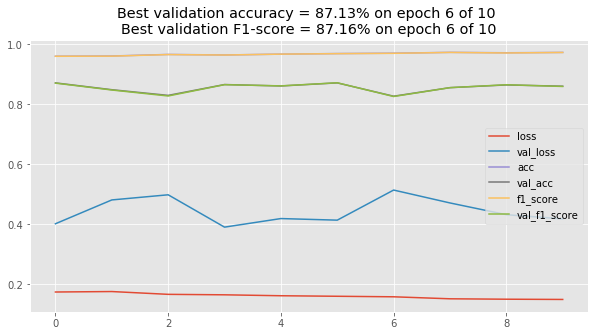

In [59]:
## Flat Model Fit
model.fit(X_tra, y_tra, epochs=10, batch_size=32, validation_data=(X_val, y_val), 
          callbacks=[PlotCurves(model_name='elmo_sentence')])

In [62]:
### Flat Model results
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1331
           1       0.70      0.51      0.59       241

   micro avg       0.89      0.89      0.89      1572
   macro avg       0.81      0.73      0.76      1572
weighted avg       0.88      0.89      0.88      1572

